# Find Correlation of TF Binding Difference to logFC
In this file, I will try to create scatter plots of the TF binding differences together with the log Fold Change in the MPRA data. 
The goal is to try to find some correlation in the TFs that have a significant binding difference to the (suspected) regulatory regions, and the log Fold Change (logFC) in that enhancer between the Ancestral (Chimp) and the Derived (Human)

In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline



import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy.stats import gaussian_kde, pearsonr, spearmanr, fisher_exact
from statsmodels.stats.multitest import multipletests

from matplotlib.patches import Patch

import seaborn as sns
import pandas as pd
from functools import reduce
import utils_matanya as um
import subprocess

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Useful constants

SELECTED_RUN = "final_run_2025_04_09"

MY_DATA_DIR = "/home/labs/davidgo/matanyaw/data"
RESULTS_DIR = f"/home/labs/davidgo/matanyaw/results/{SELECTED_RUN}"
os.makedirs(RESULTS_DIR, exist_ok=True)

PLOTS_DIR = os.path.join(RESULTS_DIR, "corr_plots")
os.makedirs(PLOTS_DIR, exist_ok=True)
FULL_MPRA_FILE = "/home/labs/davidgo/Collaboration/humanMPRA/chondrocytes/comparative_analysis_combined/humanMPRA_with_seq_final2.csv"

OVERALL_TF_BINDING_DIR = os.path.join(RESULTS_DIR, "overall_tf_binding_differences")




In [4]:
mpra_use_columns = ['oligo', 'logFC_derived_vs_ancestral', 'differential_activity']

full_mpra_df = pd.read_csv(FULL_MPRA_FILE, usecols=mpra_use_columns, index_col=0)
# We will have a look only at the differencially expressing oligos
mpra_df = full_mpra_df[full_mpra_df['differential_activity'] == True]
mpra_df

,logFC_derived_vs_ancestral,differential_activity
oligo,,
seq_100038_chr6:4358790-4359059_SCREEN_a3_L1,0.299749,True
seq_100065_chr7:138979123-138979392_SCREEN_a3_L1,0.316918,True
seq_100070_chr7:79861027-79861296_SCREEN_a3_L1,-0.275615,True
seq_100075_chr16:54376420-54376689_SCREEN_a3_L1,0.318055,True
seq_100090_chr20:31380149-31380418_SCREEN_a3_L1,-0.281553,True
...,...,...
seq_99921_chr11:34262393-34262662_SCREEN_a3_L1,0.286606,True
seq_99930_chr10:128329049-128329318_SCREEN_a3_L1,-0.770237,True
seq_99966_chr21:35967796-35968065_SCREEN_a3_L1,-0.230129,True


An attempt to add the ATACseq data to get only sequences that are open in Chondrocytes:

In [ ]:
# nadavs_df = pd.read_excel("/home/labs/davidgo/Collaboration/humanMPRA/EAT/Nadav_final_2024-12-20_18-10-47.xlsx", engine='openpyxl', index_col=3)
# nadavs_df

In [5]:
TF_BINDING_DIFFERENCES_FILE = os.path.join(OVERALL_TF_BINDING_DIR, "TF_overall_binding_differences.csv")
tf_binding_differences_df = pd.read_csv(TF_BINDING_DIFFERENCES_FILE, index_col=0).T
tf_binding_differences_df


,ARX,Ahctf1,Alx3,Alx4,Ar,Arid3a,Arid5a,Ascl2,Atf3,BCL11A,...,TFAP2A,Tbx2,Tef,VAX2,VENTX,VSX1,VSX2,WT1,ZNF200,ZNF655
seq_295193_chr12:54782669-54782938_SCREEN_a2_L3,0.0000,0.0000,0.0000,0.0000,0.0000,1.162730,1.575530,4.032911,0.000,0.0000,...,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,1.5044,0.0,0.0000
seq_71981_chr12:67085937-67086206_SCREEN_a2_L1,2.7807,5.3654,2.7213,6.9911,0.0000,3.266925,2.802036,2.529784,0.000,0.0000,...,0.0000,0.0000,-0.7,4.4412,-1.7899,3.1938,2.5473,0.0000,0.0,0.0000
seq_33133_chr11:119894841-119895110_SCREEN_a1_L1,0.0000,0.0000,0.0000,0.0000,0.0000,-0.992740,3.257774,-2.118522,0.000,0.0000,...,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000
seq_248781_chr18:75279211-75279480_SCREEN_a3_L2,0.0000,0.0000,0.0000,0.0000,0.0000,1.919853,-2.676060,-1.973593,0.000,-1.2220,...,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000
seq_147743_chr2:135099118-135099387_SCREEN_a1_L2,0.0000,0.0000,0.0000,0.0000,0.0000,1.688172,1.741709,1.579540,0.000,0.0000,...,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
seq_292377_chr2:134103245-134103514_SCREEN_a2_L3,0.0000,0.0000,0.0000,0.0000,0.0000,3.398744,-1.584520,1.736507,0.000,0.0000,...,0.0000,-7.5715,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,-3.3746
seq_34252_chr7:43331359-43331628_SCREEN_a1_L1,0.0000,0.0000,0.0000,0.0000,0.0000,2.932179,-1.398006,1.877061,0.000,-3.5202,...,3.8378,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000
seq_185850_chr21:46469828-46470097_SCREEN_a2_L2,0.0000,2.5201,0.0000,0.0000,3.8692,4.098923,2.748593,3.426680,0.000,0.0000,...,0.0000,-2.4109,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,1.0320
seq_135927_chr12:43281493-43281762_SCREEN_a1_L2,4.2163,6.8531,4.5466,9.8966,0.0000,3.192678,3.571664,2.249460,1.431,0.0000,...,0.0000,0.0000,0.0,10.0000,0.0000,5.2351,4.2920,0.0000,0.0,0.0000


## Looking for Correlations
We will look for correlation of the TF binding differences in loci, and the logFC of that loci.

In [6]:
# Check the indices of both dataframes
mpra_index = set(mpra_df.index)
tf_index = set(tf_binding_differences_df.index)
# nadav_index = set(nadavs_df.index)

print("Shared loci:", len(mpra_index & tf_index))
print("Only in MPRA:", len(mpra_index - tf_index))
print("Only in TF affinity:", len(tf_index - mpra_index))

# sorted_mpra = sorted(mpra_index)
# sorted_nadav = sorted(tf_index)

# Compare the sorted lists
# for index1, index2 in zip(sorted_mpra, sorted_nadav):
#     if index1 != index2:
#         print("Different oligo names:", index1, index2)
#         break


Shared loci: 15077
Only in MPRA: 0
Only in TF affinity: 0


In [7]:
# Adding the log_FC column to the TF binding differences dataframe
tf_binding_differences_df_logfc = tf_binding_differences_df.join(mpra_df['logFC_derived_vs_ancestral'])
tf_binding_differences_df_logfc.loc[:, 'logFC_derived_vs_ancestral'] 


seq_295193_chr12:54782669-54782938_SCREEN_a2_L3    -0.170510
seq_71981_chr12:67085937-67086206_SCREEN_a2_L1      0.241081
seq_33133_chr11:119894841-119895110_SCREEN_a1_L1   -0.368757
seq_248781_chr18:75279211-75279480_SCREEN_a3_L2    -0.207360
seq_147743_chr2:135099118-135099387_SCREEN_a1_L2    0.562105
                                                      ...   
seq_292377_chr2:134103245-134103514_SCREEN_a2_L3    0.275310
seq_34252_chr7:43331359-43331628_SCREEN_a1_L1       0.273129
seq_185850_chr21:46469828-46470097_SCREEN_a2_L2     0.084888
seq_135927_chr12:43281493-43281762_SCREEN_a1_L2    -0.555110
seq_319091_chr18:22724760-22725029_SCREEN_a2_L3     0.202324
Name: logFC_derived_vs_ancestral, Length: 15077, dtype: float64

Small manual check up with the data, feel free to switch to any random loci in the MPRA file and see it is indeed the right logFC

In [45]:
tf_binding_differences_df_logfc.loc["seq_340170_chr13:96089902-96090171_SCREEN_a3_L3","logFC_derived_vs_ancestral"]

0.143364593191238

In [46]:
# tf_name = "ARX"
# output_dir = os.path.join(RESULTS_DIR, "testing_scatter_ARX")
# os.makedirs(output_dir, exist_ok=True)

# sns.scatterplot(
#     data=combined_df_logFC.loc[:, ["logFC_derived_vs_ancestral", tf_name]],
#     x="logFC_derived_vs_ancestral",
#     y=tf_name)
# plt.title(f"Correlation between TF binding and logFC for {tf_name}")
# plt.xlabel(f"TF Binding Difference: {tf_name}")
# plt.ylabel("logFC (derived vs ancestral)")
# plt.grid(False)
# plt.axhline(0, color='gray', linestyle='--', linewidth=1)
# plt.axvline(0, color='gray', linestyle='--', linewidth=1)
# plt.tight_layout()
# plt.savefig(os.path.join(output_dir, f"TF_binding_vs_logFC_{tf_name}.png"))
# plt.show()
# plt.close()


A few Attempts to draw the scatterplots with density

In [8]:
TFs = tf_binding_differences_df.columns
# TFs = ["HOXB7", "H3K27ac", "H3K4me3", "H3K9ac"]
PLOTS_RESULTS_SUB_DIR = os.path.join(PLOTS_DIR, "v2")
os.makedirs(PLOTS_RESULTS_SUB_DIR, exist_ok=True)


Scatter Plot

In [9]:
output_dir = os.path.join(PLOTS_RESULTS_SUB_DIR, "tf_mpra_scatterplots")
os.makedirs(output_dir, exist_ok=True)
for tf_name in TFs:
    # print(tf_name)
    df = tf_binding_differences_df_logfc.loc[:, ["logFC_derived_vs_ancestral", tf_name]]
    points_to_drop = df[df[tf_name] == 0].index
    df = df.drop(points_to_drop)
    # df["abs_binding"] = df[tf_name].abs()
    # threshold = df["abs_binding"].quantile(0.9)
    # df = df[df["abs_binding"] >= threshold]

    sns.scatterplot(
        data=df,
        x=tf_name,
        y="logFC_derived_vs_ancestral",)
    plt.title(f"Correlation Between TF Binding-Difference and logFC for {tf_name}")
    plt.xlabel(f"TF Binding Difference: {tf_name} to Enhancer")
    plt.ylabel("logFC (Derived vs Ancestral) of Enhancer")
    plt.grid(False)
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.axvline(0, color='gray', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{tf_name}_TF_scatterplot.png"))
    plt.close()

Scatter Density Plot

In [32]:
output_dir = os.path.join(PLOTS_RESULTS_SUB_DIR, "TF_density_scatter")
os.makedirs(output_dir, exist_ok=True)

for tf_name in TFs:
    df = tf_binding_differences_df_logfc.loc[:, ["logFC_derived_vs_ancestral", tf_name]]
    points_to_drop = df[df[tf_name] == 0].index
    df = df.drop(points_to_drop)
    
    # df["abs_binding"] = df[tf_name].abs()
    # threshold = df["abs_binding"].quantile(0.9)
    # df = df[df["abs_binding"] >= threshold]

    if df.shape[0] < 5:
        print(f"⚠️ Skipping {tf_name}, not enough data.")
        continue

    x = df[tf_name].values
    y = df["logFC_derived_vs_ancestral"].values

    # Stack for KDE evaluation
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)  # density at each point

    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, c=z, s=12, cmap='inferno', edgecolor='none', alpha=0.7)
    plt.colorbar(label="Density")
    plt.title(f"Density-Weighted Scatter: {tf_name}")
    plt.xlabel(f"TF Binding Difference: {tf_name}")
    plt.ylabel("logFC (Derived vs Ancestral) of Enhancer")
    plt.grid(False)
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.axvline(0, color='gray', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{tf_name}_TF_density_scatter.png"))
    plt.close()

KDE Plot

In [50]:
output_dir = os.path.join(PLOTS_RESULTS_SUB_DIR, "tf_mpra_kdeplots")
os.makedirs(output_dir, exist_ok=True)

for i, tf_name in enumerate(TFs):
    df = tf_binding_differences_df_logfc.loc[:, ["logFC_derived_vs_ancestral", tf_name]]
    points_to_drop = df[df[tf_name] == 0].index
    df = df.drop(points_to_drop)
    
    # df["abs_binding"] = df[tf_name].abs()
    # threshold = df["abs_binding"].quantile(0.9)
    # df = df[df["abs_binding"] >= threshold]

    plt.figure(figsize=(8, 6))
    sns.kdeplot(
        data=df,
        x=tf_name,
        y="logFC_derived_vs_ancestral",
        fill=True,
        cmap="coolwarm",
        thresh=0.05,
        levels=20
    )
    plt.title(f"Density Between TF Binding-Diff and logFC for {tf_name}")
    plt.xlabel(f"TF Binding Difference: {tf_name} to Enhancer")
    plt.ylabel("logFC (Derived vs Ancestral) of Enhancer")
    plt.grid(False)
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.axvline(0, color='gray', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{tf_name}_TF_binding_kdeplot.png"))
    plt.close()


Calculate Spearman Correlation 

In [22]:
correlation_results = []

for tf_name in TFs:
    df = tf_binding_differences_df_logfc.loc[:, ["logFC_derived_vs_ancestral", tf_name]]

    points_to_drop = df[df[tf_name] == 0].index
    df = df.drop(points_to_drop)


    x = df[tf_name].values
    y = df["logFC_derived_vs_ancestral"].values

    pearson_r, pearson_p = pearsonr(x, y)
    spearman_r, spearman_p = spearmanr(x, y)
     # Fisher's test contingency table
    A = ((x > 0) & (y > 0)).sum()
    B = ((x > 0) & (y < 0)).sum()
    C = ((x < 0) & (y > 0)).sum()
    D = ((x < 0) & (y < 0)).sum()

    contingency_table = [[A, B], [C, D]]

    # Fisher test (two-sided)
    fisher_oddsratio, fisher_p = fisher_exact(contingency_table)

    correlation_results.append({
        "TF": tf_name,
        "Pearson_r": pearson_r,
        "Pearson_p": pearson_p,
        "Spearman_r": spearman_r,
        "Spearman_p": spearman_p,
        "Fisher_oddsratio": fisher_oddsratio,
        "Fisher_p": fisher_p,
        "n_points": len(x)
    })

correlation_df = pd.DataFrame(correlation_results)
correlation_df.sort_values(by="Spearman_r", ascending=False, inplace=True)


In [23]:
# Apply Benjamini-Hochberg FDR correction
correlation_df["Pearson_p_adj"] = multipletests(correlation_df["Pearson_p"], method='fdr_bh')[1]
correlation_df["Spearman_p_adj"] = multipletests(correlation_df["Spearman_p"], method='fdr_bh')[1]
correlation_df["Fisher_p_adj"] = multipletests(correlation_df["Fisher_p"], method='fdr_bh')[1]


In [12]:
correlation_df

,TF,Pearson_r,Pearson_p,Spearman_r,Spearman_p,Fisher_oddsratio,Fisher_p,n_points,Pearson_p_adj,Spearman_p_adj,Fisher_p_adj
71,Gabpa,0.217207,4.782607e-20,0.295335,2.118440e-36,3.110882,5.471059e-31,1742,2.845651e-18,2.520943e-34,6.510560e-29
33,EGR2,0.240695,5.103468e-23,0.280490,5.419647e-31,2.931034,5.820866e-25,1638,6.073127e-21,3.224690e-29,1.385366e-23
8,Atf3,0.176082,2.860968e-18,0.216885,4.215322e-27,2.159622,9.028629e-21,2415,1.134851e-16,1.003247e-25,7.162712e-20
39,Elf4,0.166321,6.275968e-16,0.210737,8.069518e-25,2.254161,5.500257e-22,2332,1.244734e-14,1.066970e-23,5.454421e-21
37,Elf1,0.164878,3.359507e-17,0.192548,5.414136e-23,2.049835,2.001838e-19,2583,9.994533e-16,4.956016e-22,1.323437e-18
...,...,...,...,...,...,...,...,...,...,...,...
9,BCL11A,-0.077296,1.017334e-04,-0.084361,2.206737e-05,0.749814,3.342936e-04,2523,3.668568e-04,8.206302e-05,1.283256e-03
103,Rarg,-0.080767,2.933595e-04,-0.090061,5.358810e-05,0.657553,3.258140e-06,2006,9.435076e-04,1.932419e-04,1.491226e-05
48,Esrrb,-0.111409,2.360322e-04,-0.101662,7.979171e-04,0.611465,6.069533e-05,1085,7.802176e-04,2.373803e-03,2.675091e-04
110,Tbx2,-0.099824,5.862467e-08,-0.116506,2.373663e-10,0.608382,2.186228e-11,2939,3.033190e-07,1.283936e-09,1.238862e-10


In [33]:
# highlight_tfs = ["SNAI2", "ALX3", "ALX4", 'DLX5', 'DLX1', 'MSX2', 'PAX3', 'PAX7', 'SOX3', 'BARX2', 'EN1', 'HOXD13', 'TBX2', 'FOXC1', 'SNAI2', 'EGR2', 'GLI1', 'IRX2', 'NKX2-5']  # example TFs to mark
highlight_tfs = ["SNAI2",  'PAX7', 'EGR2']  # example TFs to mark

significance_threshold = 0.05



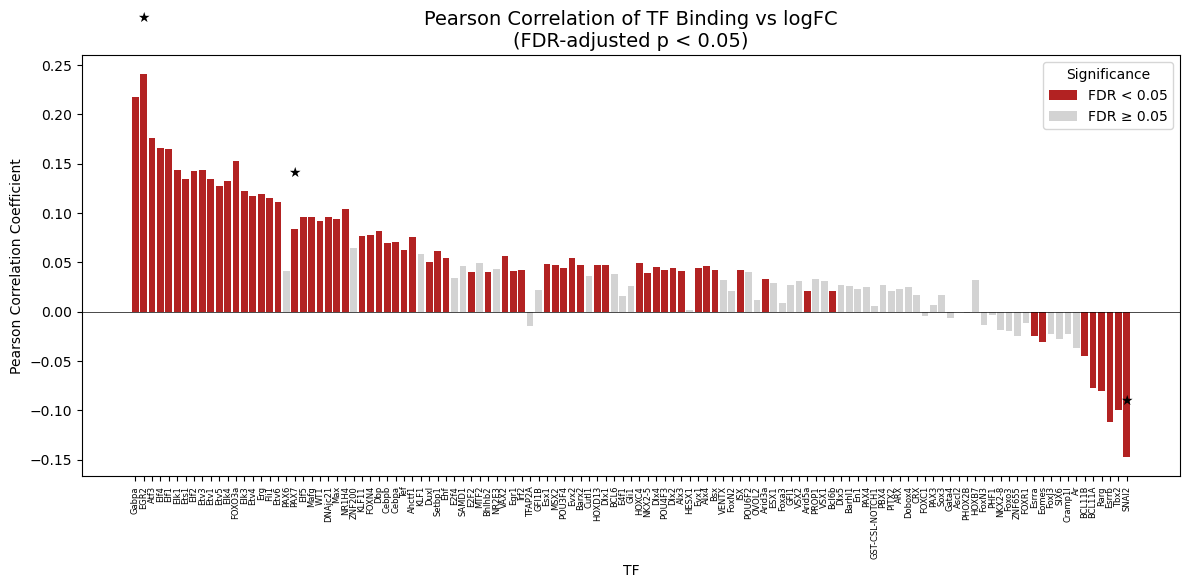

In [34]:
significant_pearson = correlation_df['Pearson_p_adj'] < significance_threshold
colors_pearson = ['firebrick' if sig else 'lightgray' for sig in significant_pearson]


# Create a bar plot of the correlations
plt.figure(figsize=(12, 6))
bars = plt.bar(correlation_df['TF'], correlation_df['Pearson_r'], color=colors_pearson)
plt.axhline(0, color='black', linewidth=0.5)
plt.xticks(rotation=90, fontsize=6)

plt.xlabel('TF')
plt.ylabel('Pearson Correlation Coefficient')
plt.title('Pearson Correlation of TF Binding vs logFC\n(FDR-adjusted p < 0.05)', fontsize=14)

legend_elements = [
    Patch(facecolor='firebrick', label='FDR < 0.05'),
    Patch(facecolor='lightgray', label='FDR ≥ 0.05')
]

for bar, tf_name in zip(bars, correlation_df["TF"]):
    if tf_name in highlight_tfs:
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.05,
            "★", ha="center", va="bottom",
            fontsize=10, color="black", fontweight="bold"
        )
plt.legend(handles=legend_elements, loc='upper right', title="Significance")

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_RESULTS_SUB_DIR, "pearson_correlation_barplot_fdr.png"))
plt.show()
plt.close()



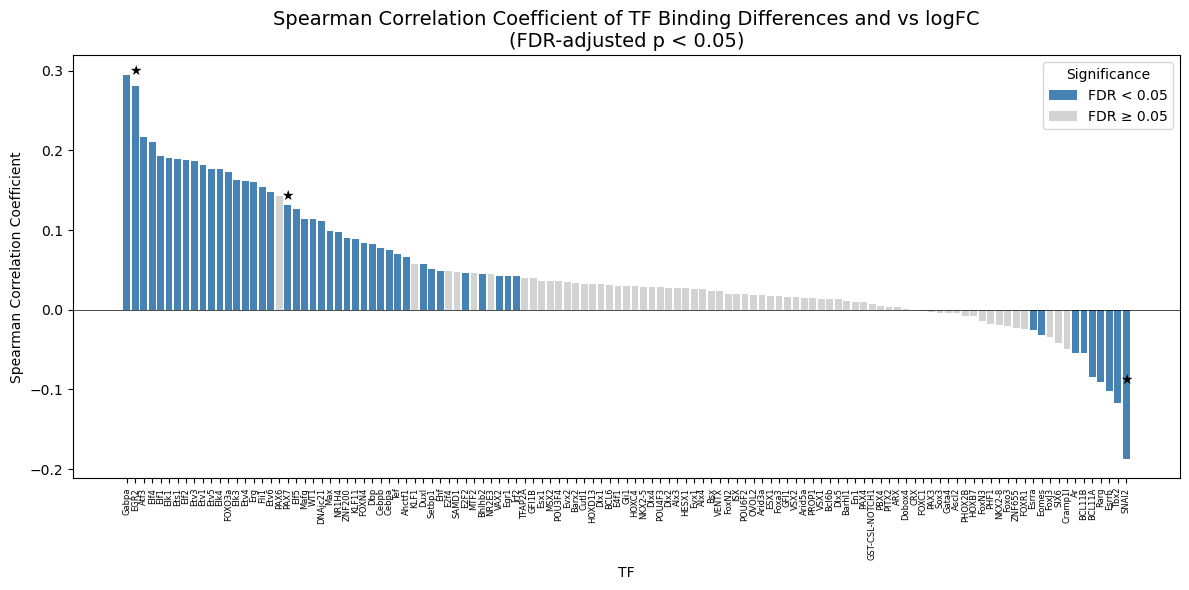

In [35]:
significant_spearman = correlation_df['Spearman_p_adj'] < significance_threshold
colors_spearman = ['steelblue' if sig else 'lightgray' for sig in significant_spearman]



plt.figure(figsize=(12, 6))
plt.bar(correlation_df['TF'], correlation_df['Spearman_r'], color=colors_spearman)
plt.axhline(0, color='black', linewidth=0.5)
legend_elements = [
    Patch(facecolor='steelblue', label='FDR < 0.05'),
    Patch(facecolor='lightgray', label='FDR ≥ 0.05')
]
for bar, tf_name in zip(bars, correlation_df["TF"]):
    if tf_name in highlight_tfs:
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.05,
            "★", ha="center", va="bottom",
            fontsize=10, color="black", fontweight="bold"
        )
plt.legend(handles=legend_elements, loc='upper right', title="Significance")
plt.xticks(rotation=90, fontsize=6)

plt.xlabel('TF')
plt.ylabel('Spearman Correlation Coefficient')
plt.title('Spearman Correlation Coefficient of TF Binding Differences and vs logFC\n(FDR-adjusted p < 0.05)', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_RESULTS_SUB_DIR, "spearman_correlation_barplot_fdr.png"))
plt.show()
plt.close()


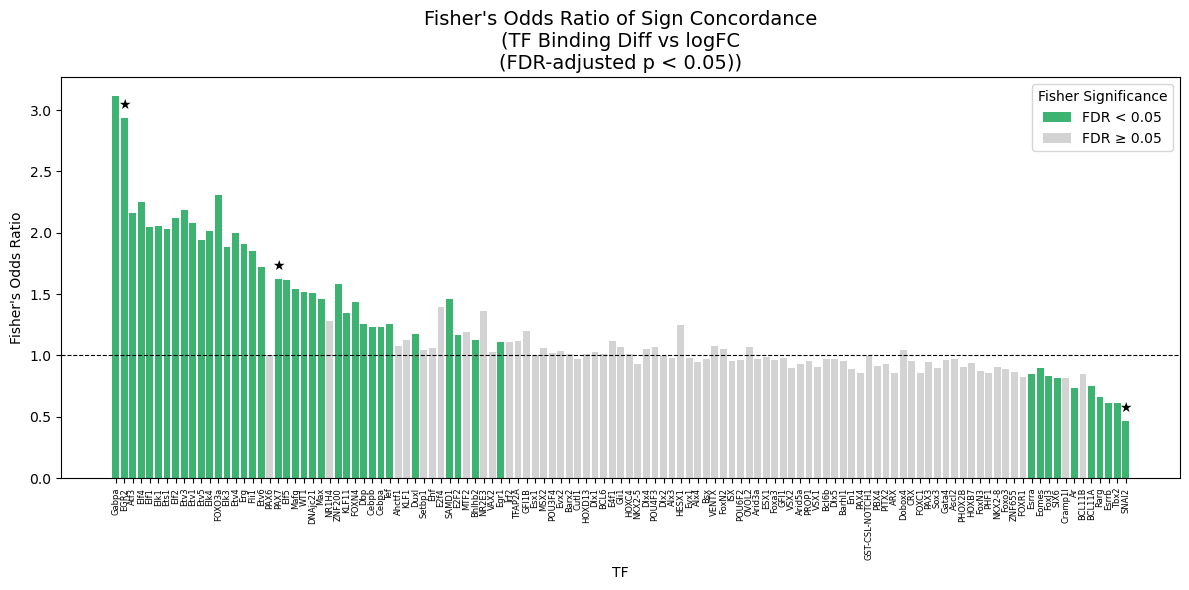

In [36]:
from matplotlib.patches import Patch

sig_fisher = correlation_df["Fisher_p_adj"] < 0.05
colors = ['mediumseagreen' if sig else 'lightgray' for sig in sig_fisher]

plt.figure(figsize=(12, 6))
bars = plt.bar(correlation_df["TF"], correlation_df["Fisher_oddsratio"], color=colors)

legend_elements = [
    Patch(facecolor='mediumseagreen', label='FDR < 0.05'),
    Patch(facecolor='lightgray', label='FDR ≥ 0.05')
]

for bar, tf_name in zip(bars, correlation_df["TF"]):
    if tf_name in highlight_tfs:
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.05,
            "★", ha="center", va="bottom",
            fontsize=10, color="black", fontweight="bold"
        )

plt.legend(handles=legend_elements, loc='upper right', title="Fisher Significance")

plt.axhline(1, color='black', linewidth=0.8, linestyle="--")
plt.ylabel("Fisher's Odds Ratio")
plt.xlabel("TF")

# plt.xticks(rotation=90, fontsize=6)
plt.xticks(ticks=range(len(correlation_df)), labels=correlation_df["TF"], rotation=90, fontsize=6)

plt.title("Fisher's Odds Ratio of Sign Concordance\n(TF Binding Diff vs logFC\n(FDR-adjusted p < 0.05))", fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_RESULTS_SUB_DIR, "fisher_odds_ratio_barplot_fdr.png"))
plt.show()
plt.close()


In [29]:
list(TFs)

['ARX',
 'Ahctf1',
 'Alx3',
 'Alx4',
 'Ar',
 'Arid3a',
 'Arid5a',
 'Ascl2',
 'Atf3',
 'BCL11A',
 'BCL11B',
 'BCL6',
 'Barhl1',
 'Barx2',
 'Bcl6b',
 'Bhlhb2',
 'Bsx',
 'CRX',
 'Cebpa',
 'Cebpb',
 'Cramp1l',
 'Cutl1',
 'DNAjc21',
 'Dbp',
 'Dlx1',
 'Dlx2',
 'Dlx4',
 'Dlx5',
 'Dobox4',
 'Duxl',
 'E2F2',
 'E2f4',
 'E4f1',
 'EGR2',
 'ESX1',
 'Egr1',
 'Ehf',
 'Elf1',
 'Elf2',
 'Elf4',
 'Elf5',
 'Elk1',
 'Elk3',
 'Elk4',
 'En1',
 'Eomes',
 'Erg',
 'Esrra',
 'Esrrb',
 'Esx1',
 'Ets1',
 'Etv1',
 'Etv3',
 'Etv4',
 'Etv5',
 'Etv6',
 'Evx1',
 'Evx2',
 'FOXC1',
 'FOXN4',
 'FOXO3a',
 'FOXR1',
 'Fli1',
 'FoxJ3',
 'FoxN2',
 'FoxN3',
 'Foxa3',
 'Foxo3',
 'GFI1',
 'GFI1B',
 'GST-CSL-NOTCH1',
 'Gabpa',
 'Gata4',
 'Gli1',
 'HESX1',
 'HOXB7',
 'HOXC4',
 'HOXD13',
 'ISX',
 'Irf2',
 'KLF1',
 'KLF11',
 'MSX2',
 'MTF2',
 'Mafg',
 'Max',
 'NKX2-5',
 'NKX2-8',
 'NR1H4',
 'NR2E3',
 'OVOL2',
 'PAX3',
 'PAX4',
 'PAX6',
 'PAX7',
 'PBX4',
 'PHF1',
 'PHOX2B',
 'PITX2',
 'POU3F4',
 'POU4F3',
 'POU6F2',
 'PROP1',
 'Rarg'

In [58]:
# mpra_df.loc[:, "logFC_derived_vs_ancestral"].hist(bins=1000)
# plt.title("MPRA logFC (derived vs ancestral) distribution")
# plt.xlabel("logFC (derived vs ancestral)")
# plt.ylabel("Frequency")
# plt.grid(True)
# plt.tight_layout()
# plt.savefig(os.path.join(RESULTS_DIR, "MPRA_logFC_distribution.png"))
# plt.show()
# plt.close()

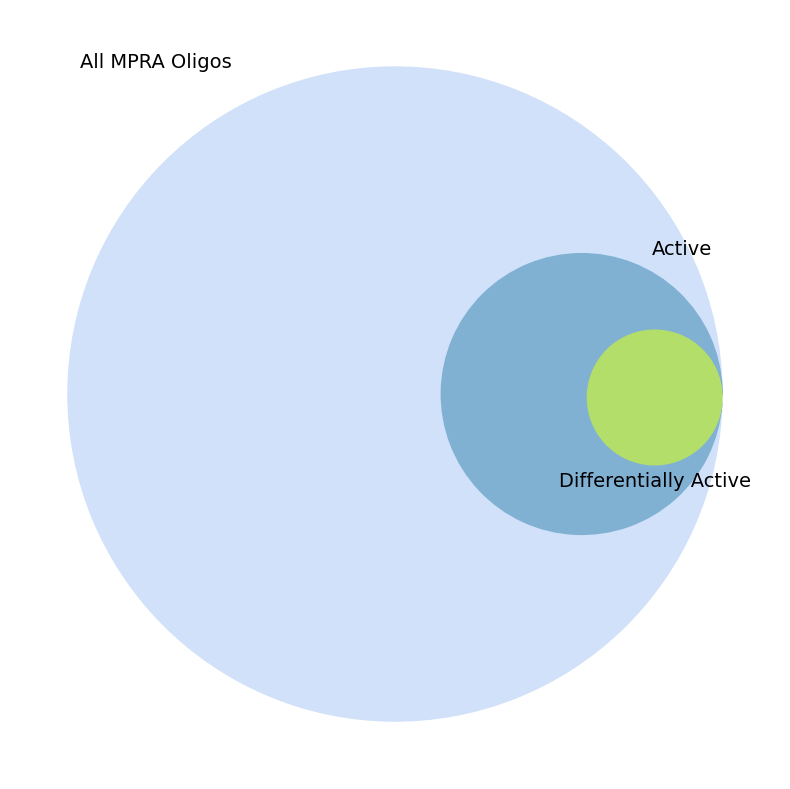

In [60]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# 1. Build actual sets
set_all = set(full_mpra_df.index)
set_active = set(full_mpra_df[full_mpra_df["differential_activity"].notna()].index)
set_diff = set(mpra_df.index)

# 2. Plot
plt.figure(figsize=(8, 8))
v = venn3([set_all, set_active, set_diff],
          set_labels=("All MPRA Oligos", "Active", "Differentially Active"))

# 3. Assign custom colors
colors = {
    '100': '#d0e1f9',  # Only All
    '010': '#a6c8ff',  # Only Active
    '001': '#ffcccc',  # Only Diff
    '110': '#80b1d3',
    '101': '#fb8072',
    '011': '#fdb462',
    '111': '#b3de69',  # All three
}

for subset, color in colors.items():
    patch = v.get_patch_by_id(subset)
    if patch:
        patch.set_color(color)
        patch.set_alpha(1)

# 🔇 Hide all subset numbers
for label in v.subset_labels:
    if label:
        label.set_text("")  # Clear the number

# ✨ Set label font sizes
for label in v.set_labels:
    if label:
        label.set_fontsize(14)

# plt.title("Oligo Filtering Process", fontsize=16)
plt.tight_layout()
plt.show()



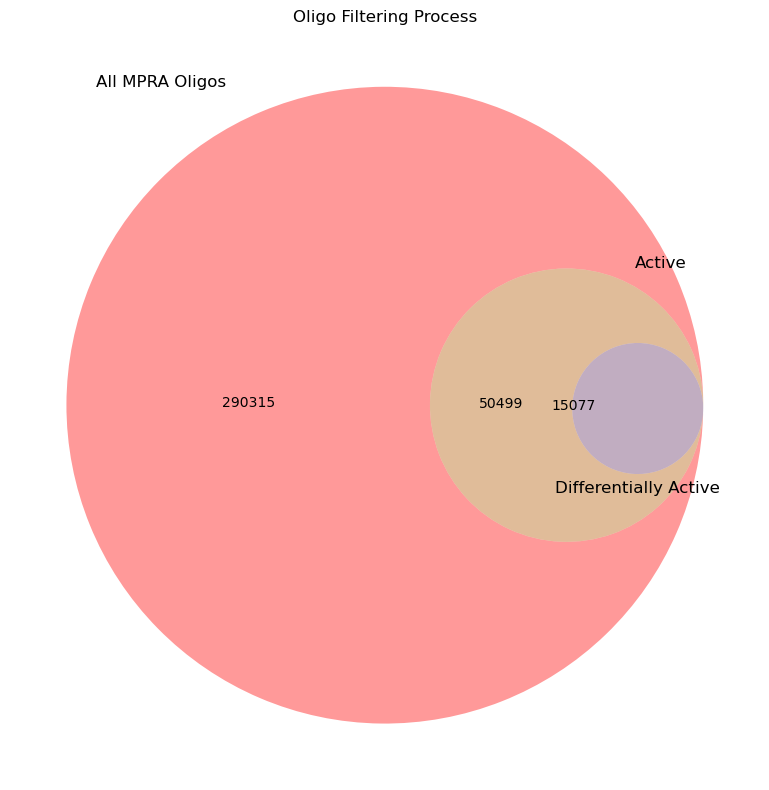

In [47]:

# 1. Build actual sets
set_all = set(full_mpra_df.index)
set_active = set(full_mpra_df[full_mpra_df["differential_activity"].notna()].index)
set_diff = set(mpra_df.index)

# 2. Plot Venn from sets
plt.figure(figsize=(8, 8))
venn3([set_all, set_active, set_diff],
      set_labels=("All MPRA Oligos", "Active", "Differentially Active"))

plt.title("Oligo Filtering Process")
plt.tight_layout()
plt.show()